# NASA Turbofan RUL 예측: 스케일러별 모델 성능 비교 워크플로우

- RUL 상한치 125로 클리핑
- 스케일링: StandardScaler, MinMaxScaler, RobustScaler
- 비시계열 모델: Linear Regression, XGBoost, RandomForest, KNN
- 시계열 모델: LSTM (seq=30, 50), TCN
- 전처리: NaN 처리, feature/target 분리
- 모델별 성능 비교 및 시각화

In [4]:
# 1. 데이터 불러오기 및 RUL 상한치 125로 클리핑
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 데이터 경로는 필요에 따라 수정하세요.
train = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
test = pd.read_csv('../CMaps/Data/test_FD001_with_RUL.csv')

# NaN 처리 (평균값 대체)
train = train.fillna(train.mean())
test = test.fillna(test.mean())

# RUL 상한치 125로 클리핑
train['RUL'] = train['RUL'].clip(upper=125)
test['RUL'] = test['RUL'].clip(upper=125)

# feature/target 분리 함수
def get_feature_target(df):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X = df[feature_cols].values
    y = df['RUL'].values
    return X, y

X_train, y_train = get_feature_target(train)
X_test, y_test = get_feature_target(test)

# 2. 스케일러별 데이터 변환
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}
scaled_data = {}
for name, scaler in scalers.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scaled_data[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

print('스케일러별 데이터 shape:', {k: v['X_train'].shape for k, v in scaled_data.items()})

스케일러별 데이터 shape: {'StandardScaler': (20631, 24), 'MinMaxScaler': (20631, 24), 'RobustScaler': (20631, 24)}


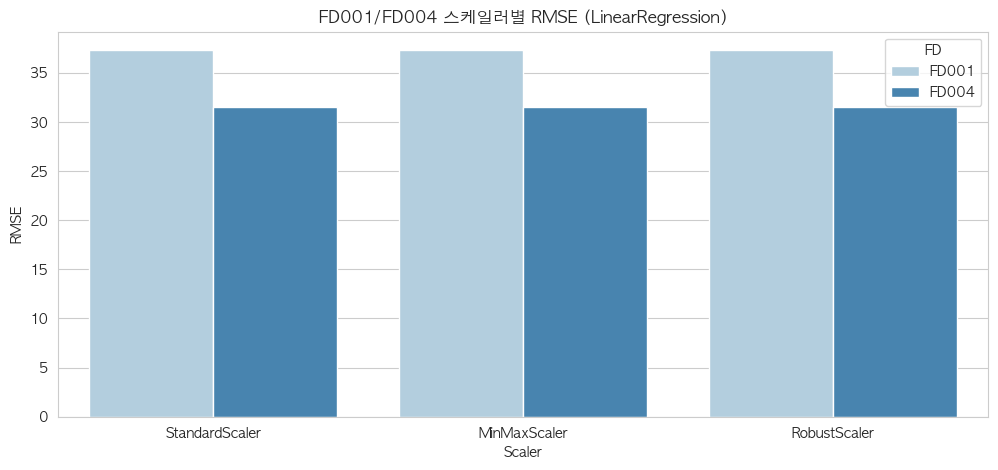

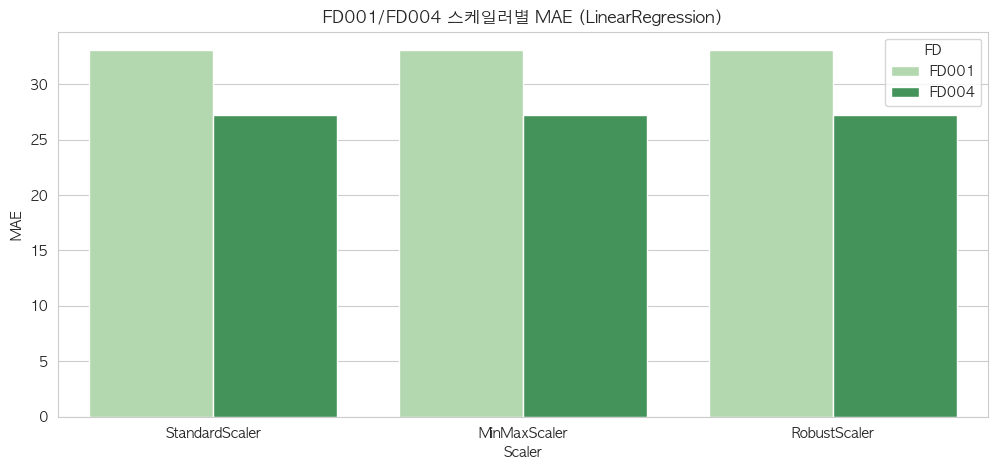

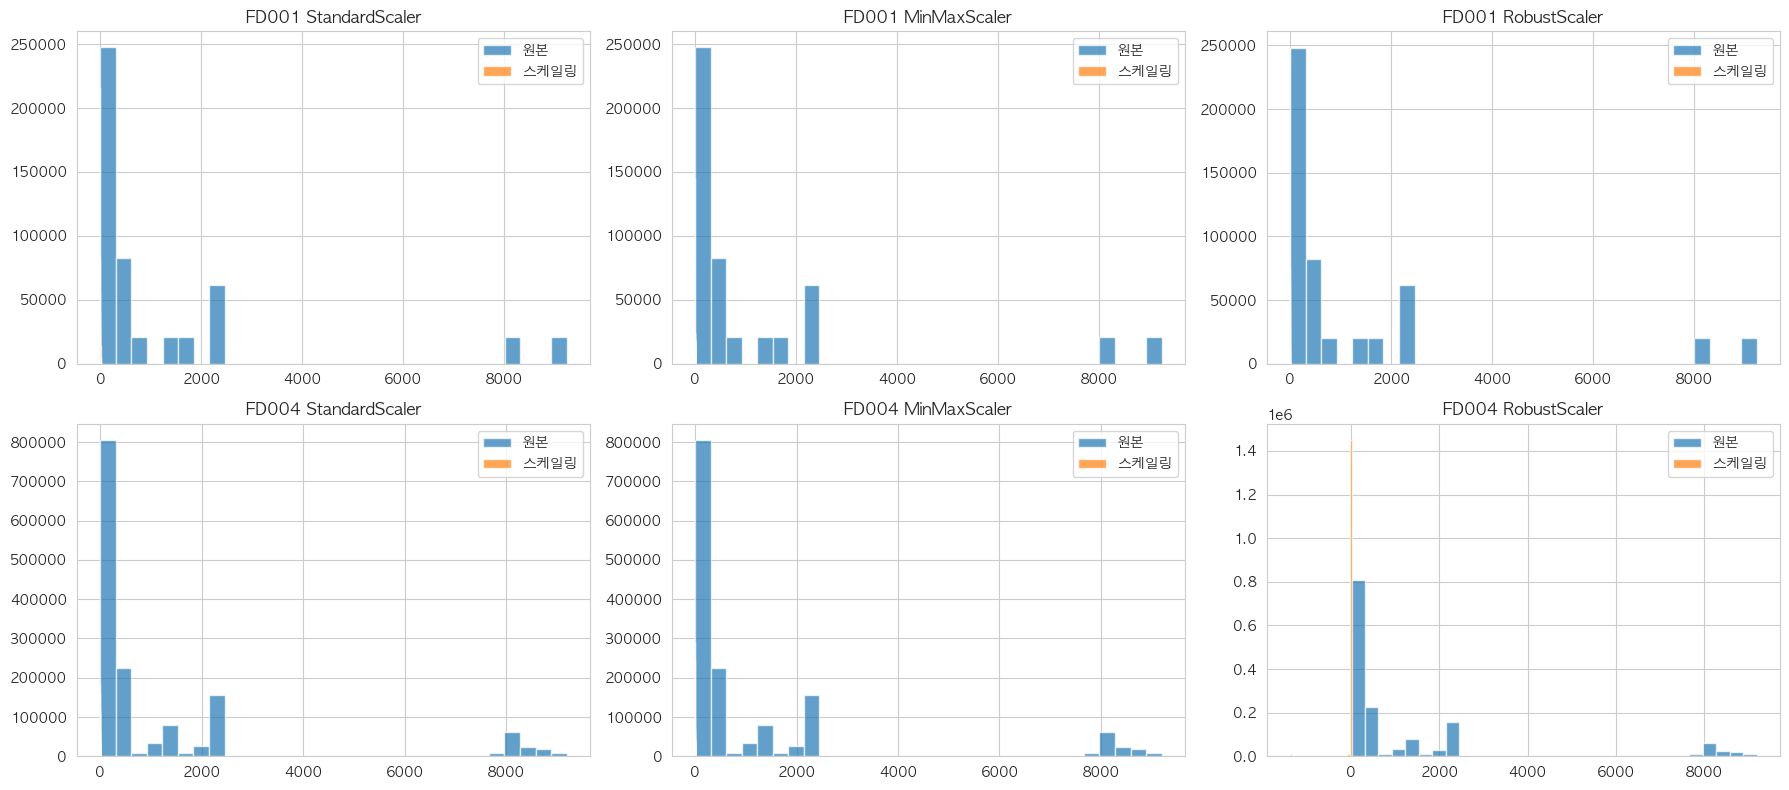

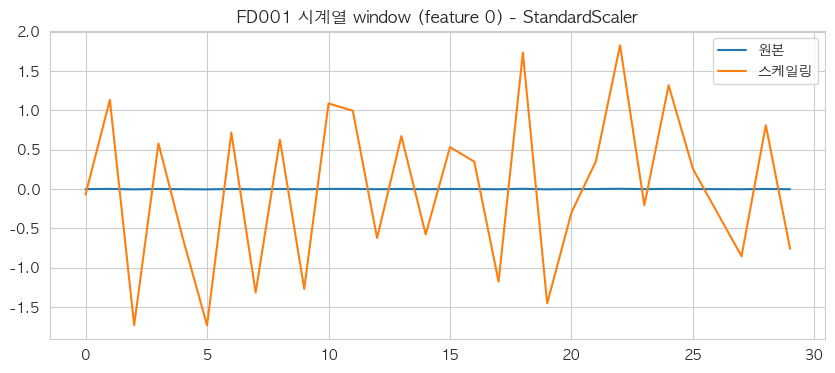

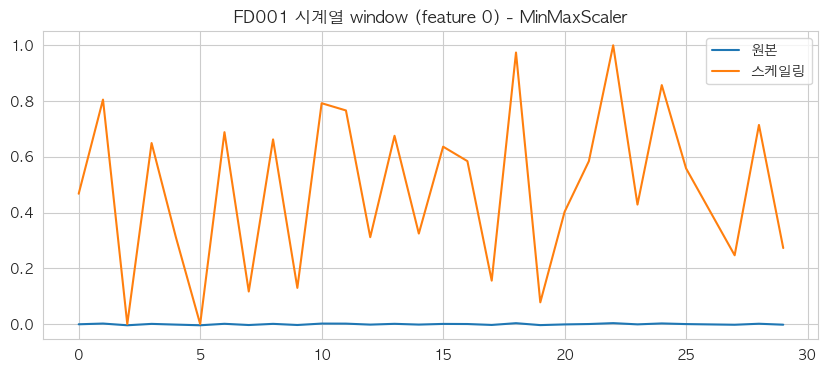

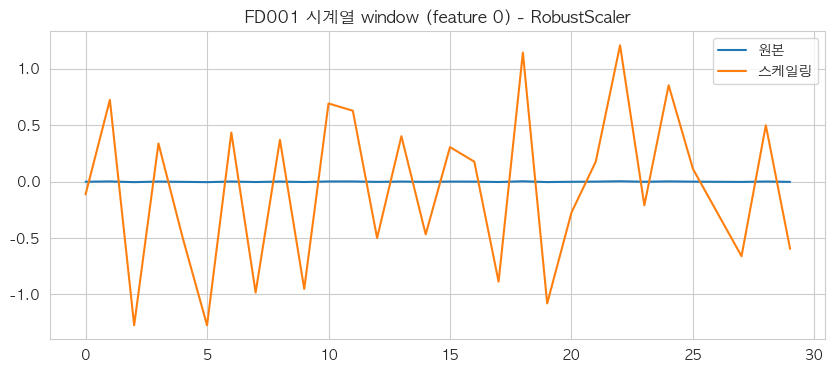

In [5]:
# 3. 스케일러별 RMSE/MAE 비교 및 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# FD001/FD004 데이터 불러오기 (이미 처리된 경우 생략)
train_fd001 = pd.read_csv('../CMaps/Data/train_FD001_with_RUL.csv')
test_fd001 = pd.read_csv('../CMaps/Data/test_FD001_with_RUL.csv')
train_fd004 = pd.read_csv('../CMaps/Data/train_FD004_with_RUL.csv')
test_fd004 = pd.read_csv('../CMaps/Data/test_FD004_with_RUL.csv')

for df in [train_fd001, test_fd001, train_fd004, test_fd004]:
    df.fillna(df.mean(), inplace=True)
    df['RUL'] = df['RUL'].clip(upper=125)

def get_feature_target(df):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X = df[feature_cols].values
    y = df['RUL'].values
    return X, y

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

results = []
for scaler_name, scaler in scalers.items():
    for fd, train_df, test_df in [('FD001', train_fd001, test_fd001), ('FD004', train_fd004, test_fd004)]:
        X_train, y_train = get_feature_target(train_df)
        X_test, y_test = get_feature_target(test_df)
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        # 비시계열 모델 예시: Linear Regression
        lr = LinearRegression()
        lr.fit(X_train_scaled, y_train)
        y_pred = lr.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        results.append({'FD': fd, 'Scaler': scaler_name, 'Model': 'LinearRegression', 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(results)

# RMSE/MAE 비교 그래프
plt.figure(figsize=(12,5))
sns.barplot(x='Scaler', y='RMSE', hue='FD', data=results_df, palette='Blues')
plt.title('FD001/FD004 스케일러별 RMSE (LinearRegression)')
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x='Scaler', y='MAE', hue='FD', data=results_df, palette='Greens')
plt.title('FD001/FD004 스케일러별 MAE (LinearRegression)')
plt.show()

# 값 분포 변화 histogram
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
for i, (scaler_name, scaler) in enumerate(scalers.items()):
    X_train, _ = get_feature_target(train_fd001)
    X_train_scaled = scaler.fit_transform(X_train)
    axes[0, i].hist(X_train.flatten(), bins=30, alpha=0.7, label='원본')
    axes[0, i].hist(X_train_scaled.flatten(), bins=30, alpha=0.7, label='스케일링')
    axes[0, i].set_title(f'FD001 {scaler_name}')
    axes[0, i].legend()
    X_train, _ = get_feature_target(train_fd004)
    X_train_scaled = scaler.fit_transform(X_train)
    axes[1, i].hist(X_train.flatten(), bins=30, alpha=0.7, label='원본')
    axes[1, i].hist(X_train_scaled.flatten(), bins=30, alpha=0.7, label='스케일링')
    axes[1, i].set_title(f'FD004 {scaler_name}')
    axes[1, i].legend()
plt.tight_layout()
plt.show()

# 시계열 window 입력에 대한 scaling 효과 시각화
seq_len = 30
def make_lstm_sequences(df, seq_len=30):
    feature_cols = [c for c in df.columns if c not in ['unit_id', 'time_cycles', 'RUL']]
    X, y = [], []
    for i in range(len(df) - seq_len + 1):
        X.append(df[feature_cols].iloc[i:i+seq_len].values)
        y.append(df['RUL'].iloc[i+seq_len-1])
    return np.array(X), np.array(y)

for scaler_name, scaler in scalers.items():
    X_seq, _ = make_lstm_sequences(train_fd001, seq_len)
    # 첫 번째 window만 시각화
    X_window = X_seq[0]
    X_window_scaled = scaler.fit_transform(X_window)
    plt.figure(figsize=(10,4))
    plt.plot(X_window[:,0], label='원본')
    plt.plot(X_window_scaled[:,0], label='스케일링')
    plt.title(f'FD001 시계열 window (feature 0) - {scaler_name}')
    plt.legend()
    plt.show()

In [6]:
# 4. 스케일러별 LinearRegression 모델 저장
import joblib
import os
os.makedirs('../models', exist_ok=True)

for scaler_name, scaler in scalers.items():
    X_train = scaled_data[scaler_name]['X_train']
    y_train = scaled_data[scaler_name]['y_train']
    model = LinearRegression()
    model.fit(X_train, y_train)
    joblib.dump(model, f"../models/linear_regression_{scaler_name.lower()}.pkl")
    print(f"저장 완료: ../models/linear_regression_{scaler_name.lower()}.pkl")

저장 완료: ../models/linear_regression_standardscaler.pkl
저장 완료: ../models/linear_regression_minmaxscaler.pkl
저장 완료: ../models/linear_regression_robustscaler.pkl
